# Surface Benchmarking of External Aero Flows

In this notebook, we walk through the steps required to generate a sample model inference on a simulation mesh and to compare the model's predictions with ground-truth data across several metrics relevant to external aerodynamics. This notebook uses the surface results from the [DrivAerML dataset](https://caemldatasets.org/drivaerml/). Specifically, we use sample ID `202` to compute all metrics and comparisons.

## Compute model inference on the benchmark simulation

The benchmark results are saved in `.vtp` (surface) and `.vtu` (volume) formats. For this notebook, let's start by loading the `.vtp` file and inspecting the available fields. We will use the [`pyvista`](https://pyvista.org/) library for this purpose.

### Download the benchmark solution

Let's download the solution from the [DrivAerML dataset](https://huggingface.co/datasets/neashton/drivaerml).

In [1]:
import os

filenames = [
    "drivaer_202.stl",
    "boundary_202.vtp",
]
urls = [
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/drivaer_202.stl",
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/boundary_202.vtp",
]

for filename, url in zip(filenames, urls):
    if not os.path.exists(filename):
        !wget "{url}" -O "{filename}"
    else:
        print(f"{filename} already exists. Skipping download.")

drivaer_202.stl already exists. Skipping download.
boundary_202.vtp already exists. Skipping download.


In [2]:
import pyvista as pv

mesh = pv.read("./boundary_202.vtp")
mesh

PolyData (0x73ee6907f820)
  N Cells:    8883343
  N Points:   8902069
  N Strips:   0
  X Bounds:   -9.240e-01, 3.886e+00
  Y Bounds:   -1.061e+00, 1.061e+00
  Z Bounds:   -3.176e-01, 1.074e+00
  N Arrays:   5

We observe that the mesh contains `8,902,069` points and `8,883,343` cells. The pressure and wall shear stress variables are stored as `pMeanTrim` and `wallShearStressMeanTrim`. We'll denote the model's predictions as `pMeanTrimPred` and `wallShearStressMeanTrimPred`. We compute the inference using the [DoMINO Automotive-Aero NIM](https://docs.nvidia.com/nim/physicsnemo/domino-automotive-aero/latest/overview.html), but you can adapt the code to your specific model inputs/outputs. Make sure to start the NIM container following the instructions [here](https://docs.nvidia.com/nim/physicsnemo/domino-automotive-aero/latest/quickstart-guide.html).

---
**NOTE**

If you are using a Docker container to run this notebook (e.g., the [PhysicsNeMo Docker container](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/physicsnemo/containers/physicsnemo)), ensure that you start both the NIM container and the container running this notebook with the `--network host` flag so they can communicate.

---

---
**IMPORTANT**

We are using the DrivAerML dataset with the DoMINO NIM for this example. The DoMINO NIM is trained on RANS data, whereas the DrivAerML dataset was generated using RANS-LES (HRLES) simulations. Consequently, the DoMINO NIM may show inaccuracies in turbulent quantities (e.g., turbulent viscosity and wall shear stress) relative to the ground-truth (HRLES) data. To see the true performance of the DoMINO model architecture trained on the DrivAerML dataset, refer to the [Using standardized datasets for inter-model comparisons section in README.md](../README.md#using-standardized-datasets-for-inter-model-comparisons).

---


In [3]:
import numpy as np
import os, time
from physicsnemo.cfd.bench.interpolation.interpolate_mesh_to_pc import (
    _create_nbrs_surface,
    _interpolate,
)
from physicsnemo.cfd.inference.domino_nim import call_domino_nim

output_dict = call_domino_nim(
    stl_path="./drivaer_202.stl",
    inference_api_url="http://localhost:8000/v1/infer",
    data={
        "stream_velocity": "38.89",
        "stencil_size": "1",
        "point_cloud_size": "500000",
    },
    verbose=True,
)
print("Interpolating results on the benchmarking mesh...")

# Interpolate the results of the NIM onto the mesh points
# v2 of NIM supports inference on custom point clouds. 
# you can also pass a custom point cloud directly, however for backwards
# compatability, we will continue the interpolation method.
start_time = time.time()
mesh_cell_centers = mesh.cell_centers()
nbrs_surface = _create_nbrs_surface(
    output_dict["surface_coordinates"][0, :], device="gpu"
)
fields = np.concatenate(
    [output_dict["pressure_surface"][0, :], output_dict["wall_shear_stress"][0, :]],
    axis=1,
)
fields_interp = _interpolate(
    nbrs_surface, mesh_cell_centers.points, fields, device="gpu", batch_size=10_000_000
)
mesh.cell_data["pMeanTrimPred"] = fields_interp[:, 0]
mesh.cell_data["wallShearStressMeanTrimPred"] = fields_interp[:, 1:4]
print(f"Interpolation took {time.time() - start_time:.3f} sec")

mesh

Sending POST request to DoMINO NIM inference API at http://localhost:8000/v1/infer...
Inference complete. Output keys: dict_keys(['sdf', 'coordinates', 'velocity', 'pressure', 'turbulent_kinetic_energy', 'turbulent_viscosity', 'bounding_box_dims', 'surface_coordinates', 'pressure_surface', 'wall_shear_stress', 'drag_force', 'lift_force']).
Interpolating results on the benchmarking mesh...
Interpolation took 7.705 sec


PolyData (0x73ee6907f820)
  N Cells:    8883343
  N Points:   8902069
  N Strips:   0
  X Bounds:   -9.240e-01, 3.886e+00
  Y Bounds:   -1.061e+00, 1.061e+00
  Z Bounds:   -3.176e-01, 1.074e+00
  N Arrays:   7

Now that we have both the predicted and true fields on the same points (cell centers to be precise), we can start with comparing these two solutions.

## L2 Errors

Let's compare the L2 errors for the pressure and the wall shear stress fields. We will use the `compute_l2_errors` function from the library. 

In [4]:
from physicsnemo.cfd.bench.metrics.l2_errors import compute_l2_errors

l2_errors = compute_l2_errors(
    mesh,
    true_fields=["pMeanTrim", "wallShearStressMeanTrim"],
    pred_fields=["pMeanTrimPred", "wallShearStressMeanTrimPred"],
    dtype="cell",
)
l2_errors

{'pMeanTrim_l2_error': np.float64(0.4190319335052403),
 'wallShearStressMeanTrim_x_l2_error': np.float64(0.6831535812319535),
 'wallShearStressMeanTrim_y_l2_error': np.float64(0.8277238523713482),
 'wallShearStressMeanTrim_z_l2_error': np.float64(0.7445107671102597)}

This provides a numerical comparison of the model's overall performance.

Meshes are typically refined with smaller triangles in areas of high geometric detail. We can compute area-weighted L2 errors to see how the error relates to cell size using `compute_area_weighted_l2_errors`. Note: this metric only works for `cell` dtype.

In [5]:
from physicsnemo.cfd.bench.metrics.l2_errors import compute_area_weighted_l2_errors

area_weighted_l2_errors = compute_area_weighted_l2_errors(
    mesh,
    true_fields=["pMeanTrim", "wallShearStressMeanTrim"],
    pred_fields=["pMeanTrimPred", "wallShearStressMeanTrimPred"],
    dtype="cell",
)
area_weighted_l2_errors

{'pMeanTrim_area_wt_l2_error': np.float64(0.3347586634823654),
 'wallShearStressMeanTrim_x_area_wt_l2_error': np.float64(0.4394475330423934),
 'wallShearStressMeanTrim_y_area_wt_l2_error': np.float64(0.7056855552099212),
 'wallShearStressMeanTrim_z_area_wt_l2_error': np.float64(0.6508000601879518)}

## Computing drag metrics

Drag force is an important consideration for the efficiency and performance of the vehicle. We can use the `compute_drag_and_lift` function to compute the drag and lift coefficient / forces

In [6]:
from physicsnemo.cfd.bench.metrics.aero_forces import compute_drag_and_lift

forces_true = compute_drag_and_lift(
    mesh,
    pressure_field="pMeanTrim",
    wss_field="wallShearStressMeanTrim",
    coeff=1.0,  # Set it to 1.0 to get raw forces. can be replaced 2 / (rho * u * u * ref_area) for coefficients
    drag_direction=[1, 0, 0],
    lift_direction=[0, 0, 1],
    dtype="cell",
)  # retruns F_drag, F_drag_pressure, F_drag_skin_friction, F_lift, F_lift_pressure, F_lift_skin_friction

forces_pred = compute_drag_and_lift(
    mesh,
    pressure_field="pMeanTrimPred",
    wss_field="wallShearStressMeanTrimPred",
    coeff=1.0,  # Set it to 1.0 to get raw forces. can be replaced 2 / (rho * u * u * ref_area) for coefficients
    drag_direction=[1, 0, 0],
    lift_direction=[0, 0, 1],
    dtype="cell",
)  # retruns F_drag, F_drag_pressure, F_drag_skin_friction, F_lift, F_lift_pressure, F_lift_skin_friction

labels = ["Drag Force (D)", "D_p", "D_f", "Lift Force (L)", "L_p", "L_f"]
for label, f_true, f_pred in zip(labels, forces_true, forces_pred):
    print(
        f"{label}: True: {f_true}, Pred: {f_pred}, Error (%): {abs(f_true - f_pred) * 100 / f_true}"
    )

Drag Force (D): True: 482.3444254302631, Pred: 443.4446705427987, Error (%): 8.064725709800594
D_p: True: 435.0610781379878, Pred: 405.62859491485483, Error (%): 6.765138207513454
D_f: True: 47.28334729227524, Pred: 37.816075627943874, Error (%): 20.022422705843518
Lift Force (L): True: 37.28053920122983, Pred: 193.04157490432152, Error (%): 417.8078939854855
L_p: True: 34.24916887927558, Pred: 189.28642974288204, Error (%): 452.67452010323274
L_f: True: 3.03137032195425, Pred: 3.7551451614394797, Error (%): 23.876160370225904


When computing drag and lift across many cases, you can use visualization utilities such as `physicsnemo.cfd.bench.visualization.utils.plot_design_scatter` and `physicsnemo.cfd.bench.visualization.utils.plot_design_trend` to compute metrics (e.g., R2 scores), compare design trends, and measure the ability of models to capture directional changes. The workflow scripts ([../generate_surface_benchmarks.py](../generate_surface_benchmarks.py) and [../generate_volume_benchmarks.py](../generate_volume_benchmarks.py)) use these functions to create plots like the examples below:

![Sample R2 score plot](img/design_scatter_plot.png)

![Sample design trend plot](img/design_trend_plot.png)


## Plotting fields

So far, we have examined numerical metrics, which are important for analysis. However, visualizing the flow fields is often critical for understanding flow behavior (e.g., separation regions and stagnation points).

/localhome/local-ktangsali/anaconda3/lib/python3.13/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(
ERROR:root:Could not find a decent config
2025-08-01 22:50:28.375 (  49.016s) [    73EEAC30C740]vtkXOpenGLRenderWindow.:256    ERR| vtkXOpenGLRenderWindow (0x1b493150): Could not find a decent config

2025-08-01 22:50:28.376 (  49.017s) [    73EEAC30C740]vtkXOpenGLRenderWindow.:502   WARN| vtkXOpenGLRenderWindow (0x1b493150): Could not find a decent visual



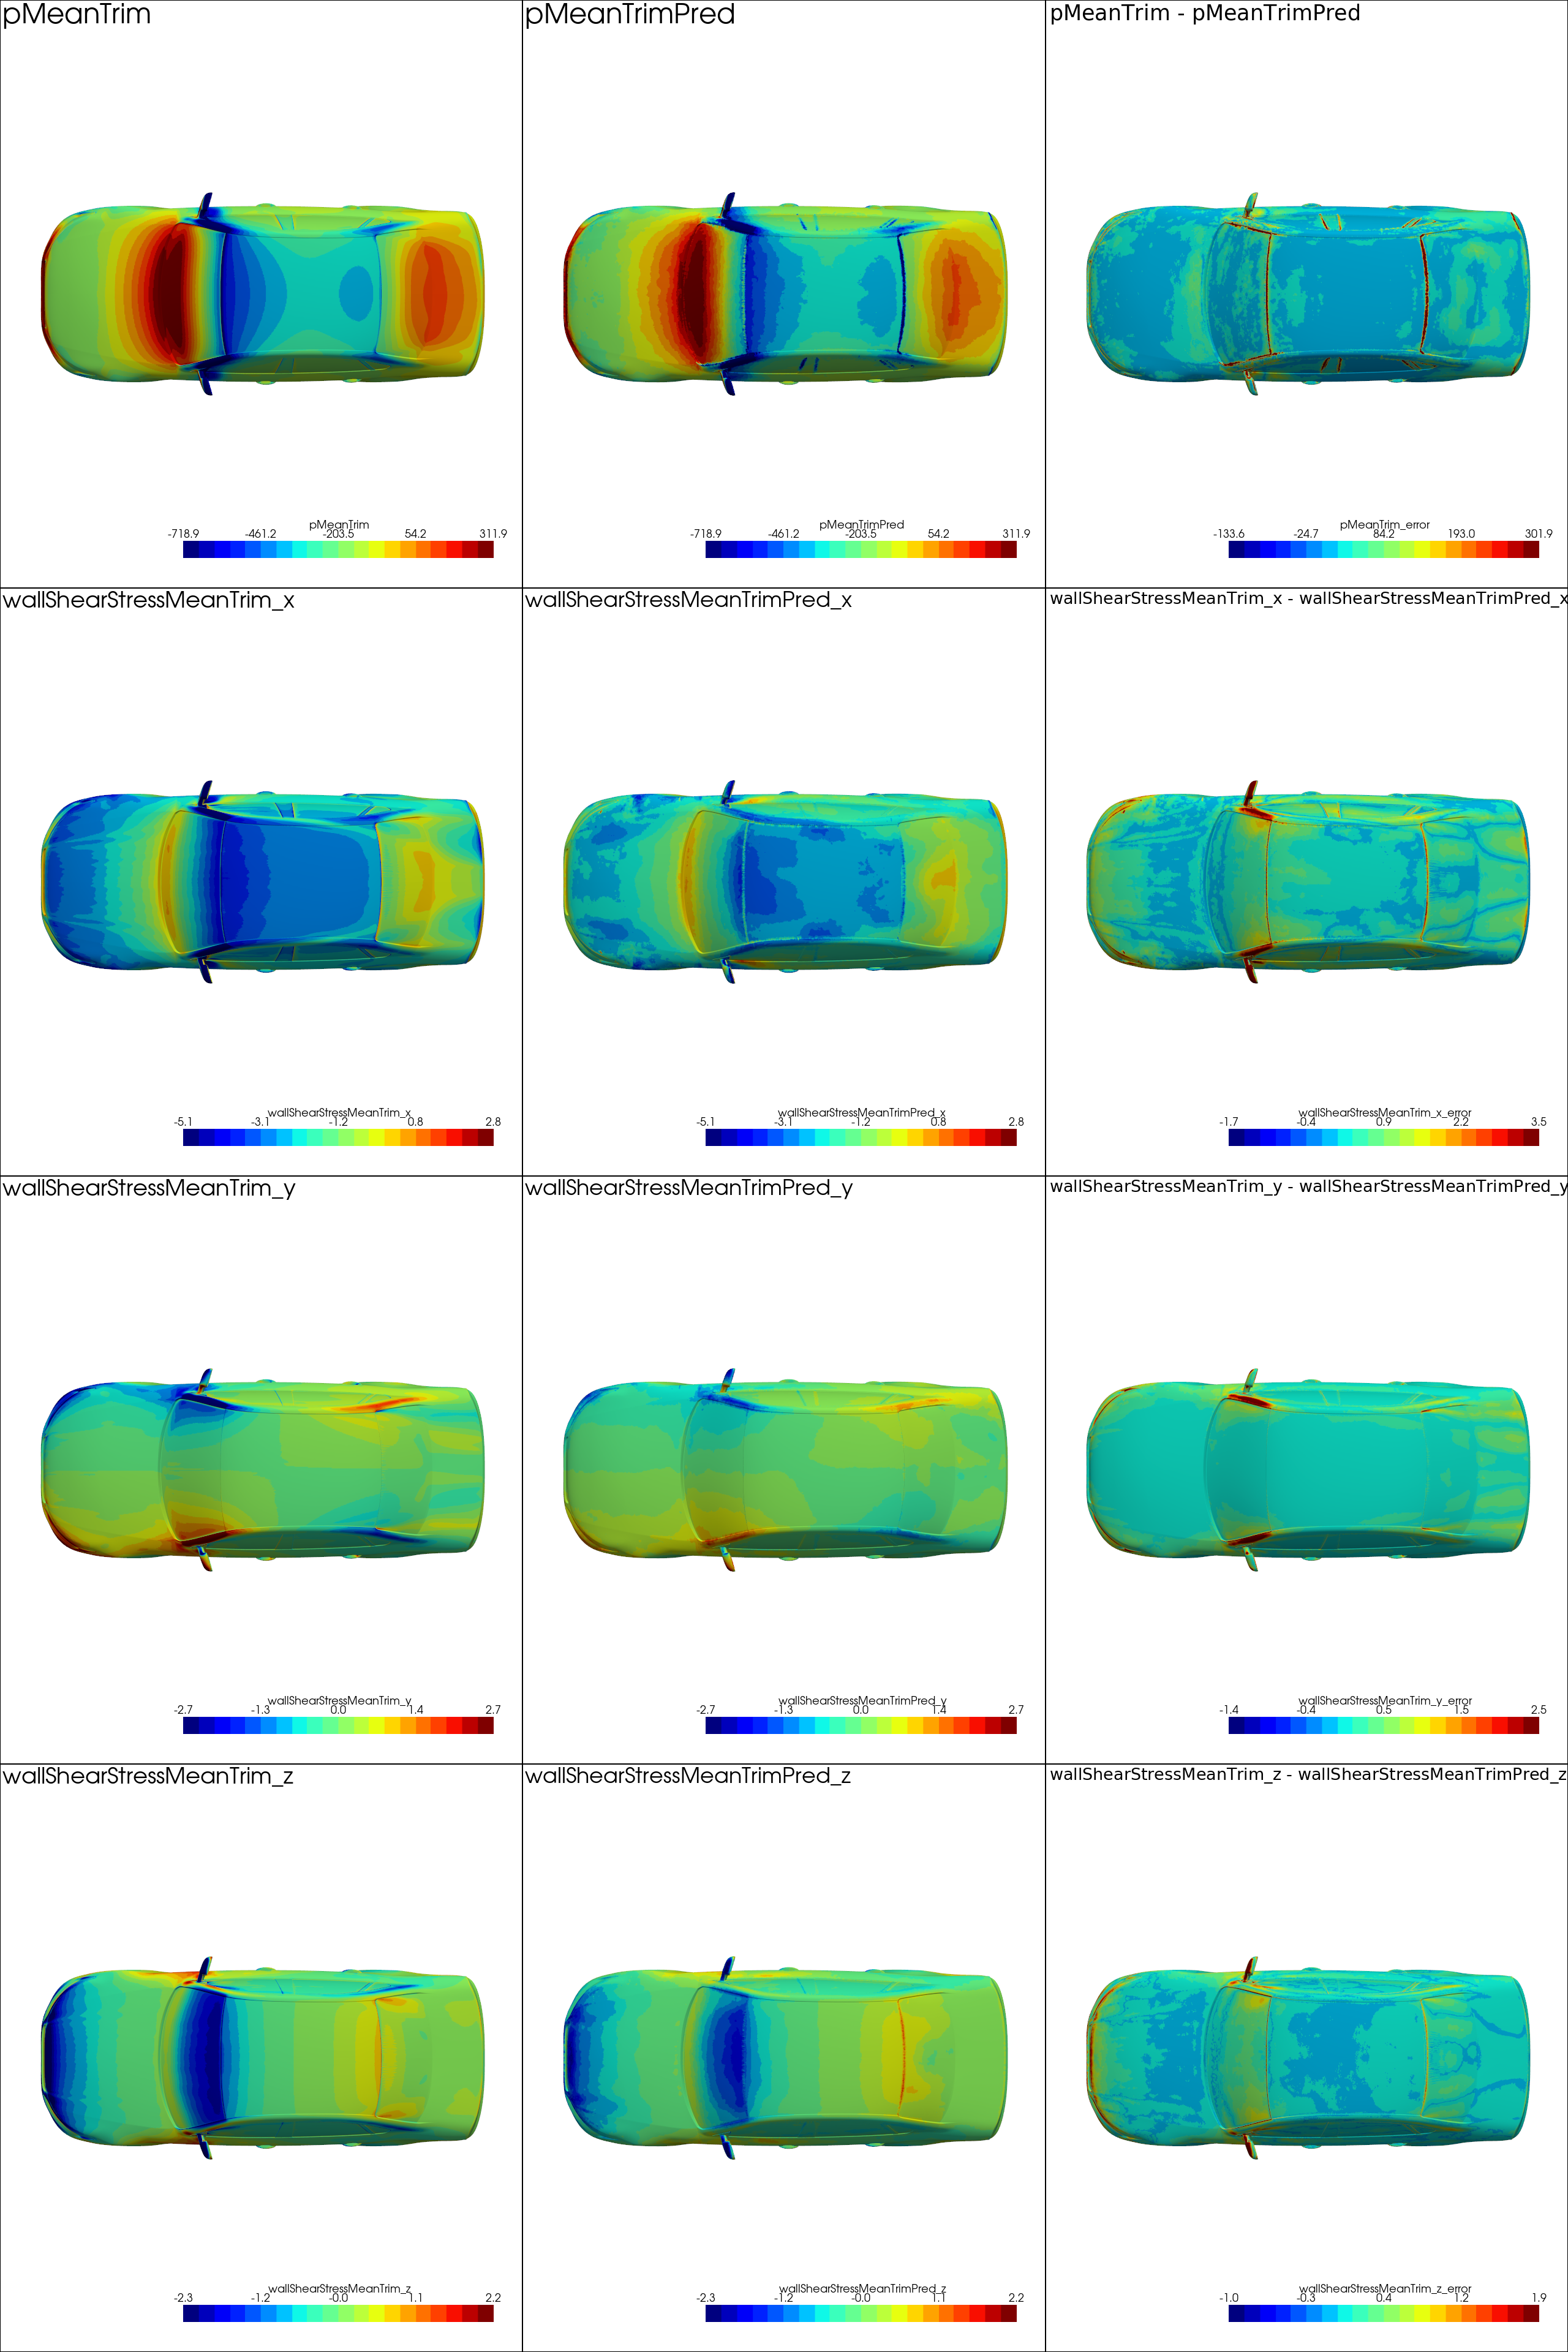

In [7]:
from physicsnemo.cfd.bench.visualization.utils import plot_field_comparisons

pv.start_xvfb()  # might require apt-get install xvfb

plotter = plot_field_comparisons(
    mesh,
    true_fields=["pMeanTrim", "wallShearStressMeanTrim"],
    pred_fields=["pMeanTrimPred", "wallShearStressMeanTrimPred"],
    view="xy",
    plot_vector_components=True,
    cmap="jet",
    lut=20,
)
plotter.screenshot("./sample_202_surface_comparison.png")

# Display the image
from IPython.display import Image

Image(filename="./sample_202_surface_comparison.png")

The visualization reveals that the AI prediction captures the larger structures in the flow field for most variables, except the x-component of wall shear stress, where it struggles with the flow structures on the hood and roof. For other variables, larger errors are observed near the mirrors and sharp edges.

Such visualizations do not show how predictions look across the entire validation dataset. For that, one can project errors from different samples onto fixed planes and build aggregate visualizations. The [`../generate_surface_benchmarks.py`](../generate_surface_benchmarks.py) script provides this capability.

Below we show the error distribution across the entire DrivAerML validation set.

![Aggregate Errors](img/hexbin_sample.png)

Overall, errors are typically higher near the intersections of the front windshield with the roof and the rear windshield with the roof. Errors are also higher near the front of the vehicle.

Such analysis is especially useful when geometric differences between samples are modest (e.g., DrivAerML), where such projections enable meaningful aggregate visualizations.

We can also create line plots for more detailed visualization and comparison. Here, we plot the pressure along the centerline of the car.

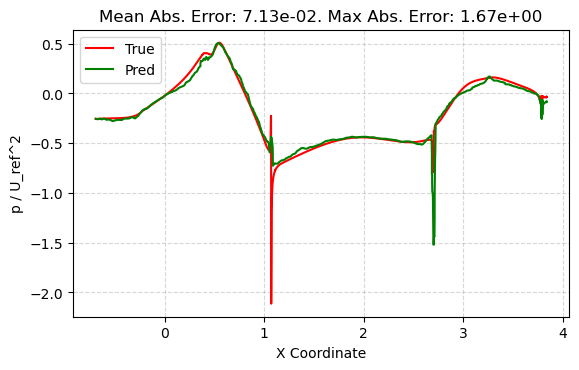

In [8]:
from physicsnemo.cfd.bench.visualization.utils import plot_line

# create a slice along xz plane
centerline = mesh.slice(origin=(0, 0, 0), normal=(0, 1, 0))
centerline = centerline.clip(
    origin=(0, 0, 0.4), normal=(0, 0, 1), invert=False
)  # Select only the top half
centerline = centerline.cell_data_to_point_data(pass_cell_data=True)

fig = plot_line(
    centerline,
    plot_coord="x",
    field_true="pMeanTrim",
    field_pred="pMeanTrimPred",
    normalize_factor=(38.89**2) / 2,
    flip=False,
    xlabel="X Coordinate",
    ylabel="p / U_ref^2",
    true_line_kwargs={"color": "red", "label": "True"},
    pred_line_kwargs={"color": "green", "label": "Pred"},
    figsize=(6, 4),
)

Aside from the sharp peaks, the centerline pressure matches the ground truth well.

Streamlines provide another way to visualize the flow fields and gain deeper insight into flow behavior. For surface results, we can create streamlines of wall shear stress. Below, we create streamlines using `physicsnemo.cfd.bench.metrics.streamlines.compute_streamlines` and overlay them on the geometry STL for clarity.

/localhome/local-ktangsali/anaconda3/lib/python3.13/site-packages/pyvista/core/filters/data_set.py:3066: PyVistaDeprecationWarning: ``max_time`` parameter is deprecated.  It will be removed in v0.48
  warnings.warn(
ERROR:root:Could not find a decent config
2025-08-01 22:52:14.845 ( 155.486s) [    73EEAC30C740]vtkXOpenGLRenderWindow.:256    ERR| vtkXOpenGLRenderWindow (0x1cdd7a60): Could not find a decent config

2025-08-01 22:52:14.845 ( 155.486s) [    73EEAC30C740]vtkXOpenGLRenderWindow.:502   WARN| vtkXOpenGLRenderWindow (0x1cdd7a60): Could not find a decent visual



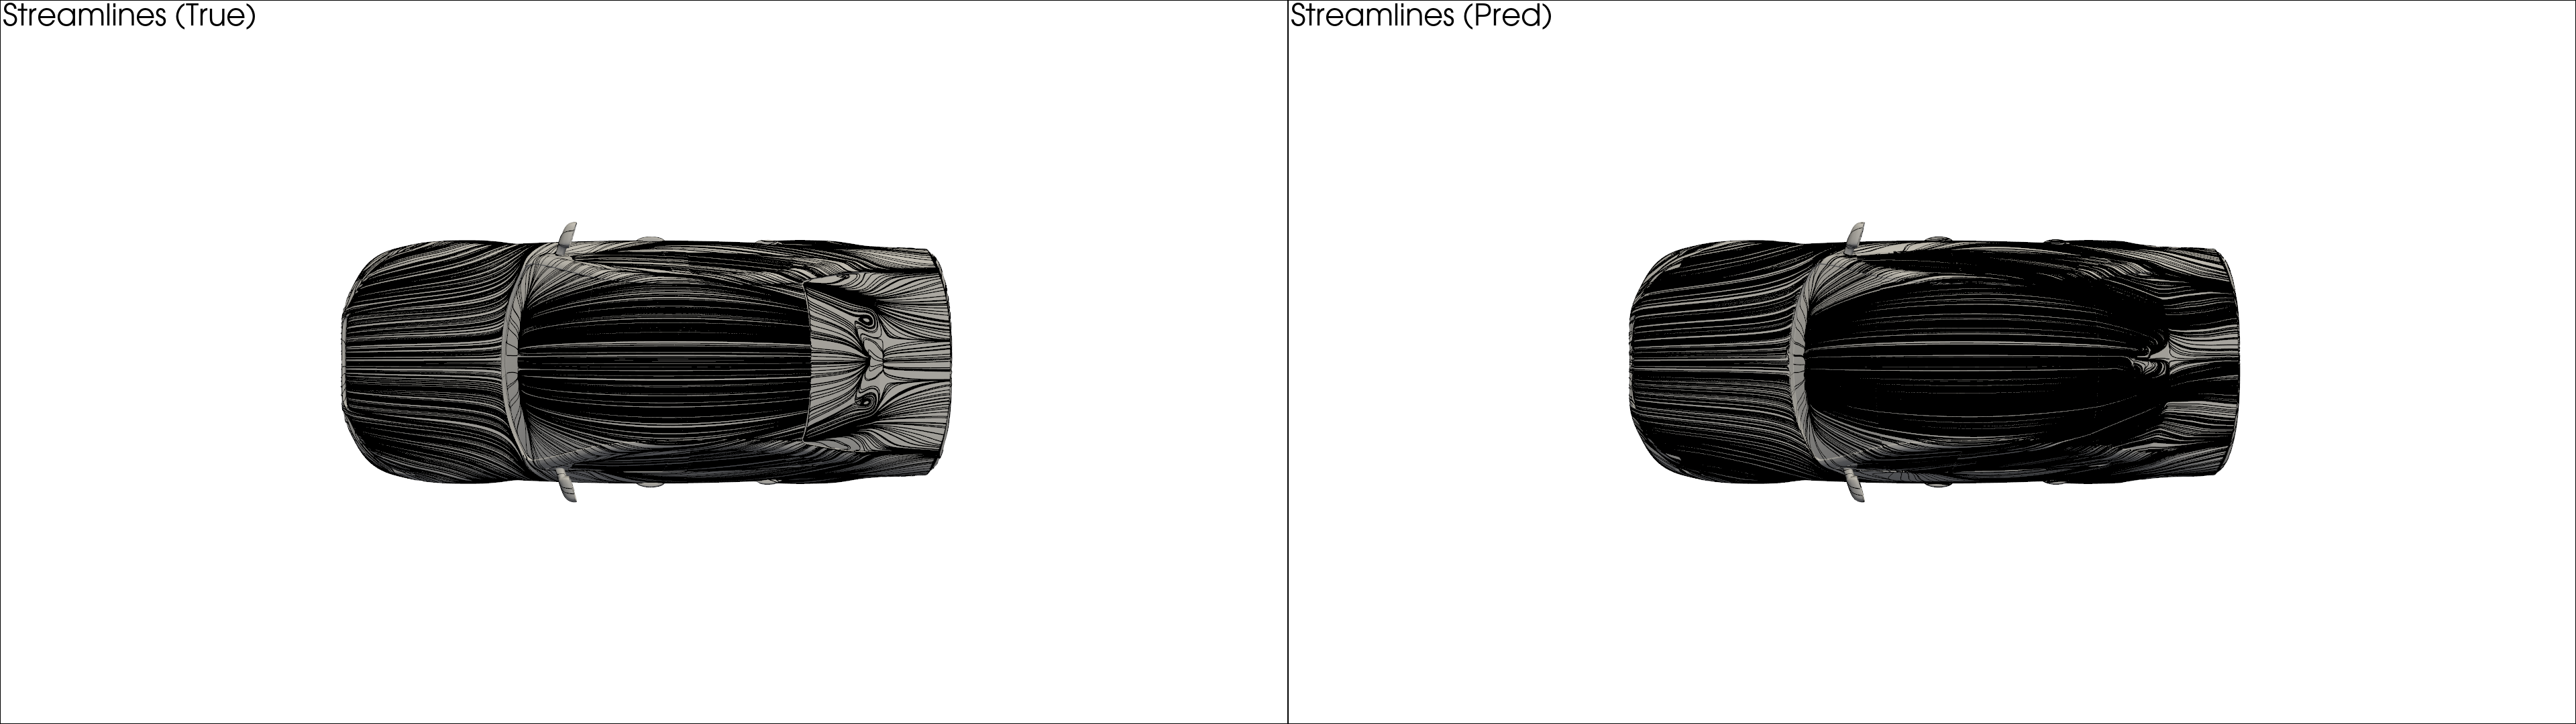

: 

In [ ]:
import numpy as np
from physicsnemo.cfd.bench.metrics.streamlines import compute_streamlines
from physicsnemo.cfd.bench.visualization.utils import plot_streamlines

true_streamlines = compute_streamlines(mesh, field="wallShearStressMeanTrim")
pred_streamlines = compute_streamlines(mesh, field="wallShearStressMeanTrimPred")

stl_mesh = pv.read("./drivaer_202.stl")
# Shrink the STL slightly
center = np.array(stl_mesh.center)
scale_factor = 0.999
stl_mesh = stl_mesh.translate(-center).scale(scale_factor).translate(center)

plotter = plot_streamlines(true_streamlines, pred_streamlines, stl_mesh, view="xy")
plotter.screenshot("./sample_202_streamlines.png")

# Display the image
from IPython.display import Image

Image(filename="./sample_202_streamlines.png")

That completes the surface benchmarking notebook. For volume benchmarking, see [`volume_benchmarking.ipynb`](./volume_benchmarking.ipynb). To run these metrics across multiple geometries or cases, refer to [`../generate_surface_benchmarks.py`](../generate_surface_benchmarks.py).